In [1]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from tqdm import tqdm

In [2]:
def dist(S,R):
    S = (S - S.min()) / (S.max() - S.min())
    R = (R - R.min()) / (R.max() - R.min())

    return np.sum((S-R)**2)

In [3]:
def generateCandidates(Ti,l):
    Wil = [np.array(Ti[i : i + l]) for i in range(0, len(Ti)-l+1, 1)]
    return Wil

In [4]:
def create_Wl(T,l):
    Wl = []
    for Ti in T:
        Wl.append(generateCandidates(Ti,l))
    return Wl

In [5]:
def findDistances(S,Wl):
    Ds = []
    for Wil in Wl:
        diS = []
        for wil in Wil:
            diS.append(dist(S,wil))
        Ds.append(np.min(diS))
    return np.array(Ds)

In [6]:
import seaborn as sns

In [7]:
def assessCandidate(S,Ds,C):
    class_groups = [Ds[C==c].tolist() for c in np.unique(C)]

#     plt.figure(figsize=(10,5))
#     colors = np.array(['red','blue','green'])
#     for c in np.unique(C):
#         sns.distplot(x=Ds[C==c],color= colors[c])
    
    return f_oneway(*class_groups).statistic

In [8]:
def sortByQuality(shapelets):
    return sorted(shapelets, key=lambda tup: tup[1],reverse=True)

In [9]:
def removeSelfSimilar(shapelets):
    queue = shapelets[:]
    df = pd.DataFrame(shapelets)

    keep_df = pd.DataFrame()

    while len(df) != 0:
        pop_item = queue.pop(0)
        s,f,interval = pop_item

        keep_df = pd.concat((keep_df,pd.DataFrame([pop_item])))

        df = df[~df[2].apply(lambda x: interval.overlaps(x))]
        queue = df.values.tolist()
    
    return keep_df.drop(2,axis=1).values.tolist()

In [10]:
def merge(k,kShapelets,shapelets):
    total_shapelets = kShapelets + shapelets
    return sortByQuality(total_shapelets)[:k]

In [11]:
import seaborn as sns

In [12]:
# plt.figure(figsize=(10,5))
# colors = np.array(['red','blue','green'])
# for c in np.unique(C):
#     sns.distplot(x=Ds[C==c],color= colors[c])

In [13]:
def generate_dataset(N,min_l,max_l):
    U = np.random.rand(N)
    classes = []
    for i in np.arange(3):
        classes.append(np.sum((U <= (i+1)*1/3) & (U > i*1/3) ))
    
    D = []
    for i,nc in enumerate(classes):
        for _ in np.arange(nc):
            size = np.random.randint(min_l,max_l+1,1)[0]
            x = np.linspace(0,1,size)
            noise = np.random.normal(0,0.1,size)
            if i == 0:
                D.append( noise +  (1.5 * x ))
            if i == 1:
                D.append( 3*(np.sin(x*(np.pi)*3)) + noise )
            if i == 2:
                #D.append( 1/100 * np.arange(np.random.randint(min_l,max_l+1,1))**3 )
                D.append( noise +  (2*np.log(x*25+1) ))

    C = [0]*classes[0] + [1] * classes[1] + [2] * classes[2]
    C = np.array(C)
    
    return D,C

In [23]:
N = 50
T,C = generate_dataset(N,20,30)

In [24]:
import matplotlib.pyplot as plt

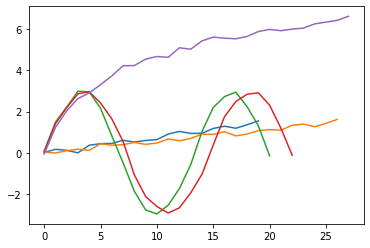

In [25]:
for Ti in T[slice(1,100,10)]:
    plt.plot(Ti)

In [70]:
lmin = 7
lmax = 15
k = 100

In [71]:
precompute_Wl = {l : create_Wl(T,l) for l in np.arange(lmin,lmax+1)}

In [73]:
kShapelets = []
for i,Ti in enumerate(tqdm(T)):
    shapelets = []
    for l in np.arange(lmin,lmax+1):
        Wl = precompute_Wl[l]
        for index,S in enumerate(Wl[i]):
            Ds = findDistances(S,Wl)
            quality = assessCandidate(S,Ds,C)
            shapelets.append((S,quality,pd.Interval(index,index+l,closed='both')))
#             print(quality,i)
#             if quality > 750:
#                 plt.figure(figsize=(10,10))
#                 sns.boxplot(y=Ds,x=C)
#                 plt.title(str(quality)+" "+str(i))
    shapelets = sortByQuality(shapelets)
    shapelets = removeSelfSimilar(shapelets) 
    kShapelets = merge(k,kShapelets,shapelets)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.56s/it]


In [74]:
i

49

Text(0.5, 1.0, '31.963080541520373 49')

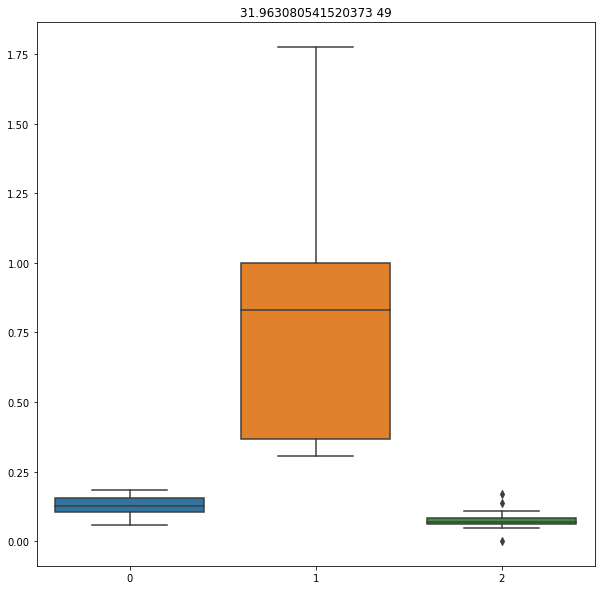

In [75]:
plt.figure(figsize=(10,10))
sns.boxplot(y=Ds,x=C)
plt.title(str(quality)+" "+str(i))

In [76]:
import matplotlib.pyplot as plt

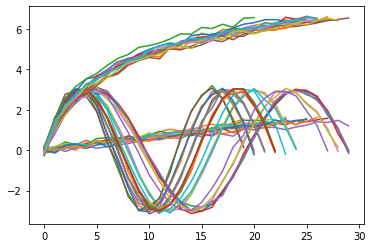

In [77]:
for Ti in T:
    plt.plot(Ti)

In [78]:
kShapelets

[[array([ 1.17255662,  2.02445393,  2.83192353,  3.00382102,  2.61198098,
          2.24013281,  1.1296732 , -0.10982048, -1.1693849 , -2.08513412,
         -2.80398027, -2.94891192, -2.69316836]),
  11622.300361264095],
 [array([ 1.41871051,  2.19098862,  2.86162303,  2.95262964,  2.41332044,
          1.6501477 ,  0.55652777, -1.05462391, -2.10214196, -2.58581558,
         -2.90086082]),
  11478.813906532181],
 [array([ 1.24991153,  2.10659289,  2.63877616,  2.92358751,  2.84322111,
          2.17334958,  1.24447475,  0.15195022, -1.11650779, -2.20933437,
         -2.79301624, -3.02593971, -2.88172333]),
  11165.816344213541],
 [array([ 1.2358197 ,  1.96616362,  2.66025214,  2.96801045,  2.84678655,
          2.07390143,  1.02570149, -0.00414702, -1.2341992 , -2.13933829,
         -2.87607123, -3.10494966, -2.61747734]),
  11132.68579954462],
 [array([ 2.5369273 ,  2.91714985,  2.99433584,  2.69185393,  1.80087043,
          0.88612637, -0.12707914, -1.21558744, -1.99203427, -2.60271

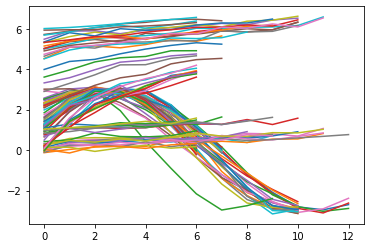

In [79]:
for shape in kShapelets:
    plt.plot(shape[0])

In [80]:
Ds

array([0.11642565, 0.09442939, 0.18486402, 0.16496518, 0.13052405,
       0.1057017 , 0.15048429, 0.16501146, 0.11992451, 0.05665335,
       0.06693762, 0.1383217 , 0.32247531, 0.83152466, 1.34349181,
       1.01962944, 0.56562455, 0.97924459, 0.5342048 , 0.50602332,
       0.30605756, 1.31160678, 1.70747859, 0.31693745, 0.33512965,
       1.77634062, 0.36677109, 0.97862924, 0.31108192, 0.67229701,
       1.27739374, 0.83054688, 0.83241144, 0.83938854, 0.36616133,
       0.048322  , 0.06210164, 0.07678438, 0.13740153, 0.06958928,
       0.06826695, 0.10879976, 0.16774586, 0.0739998 , 0.05967816,
       0.0477202 , 0.0901362 , 0.06199094, 0.06044179, 0.        ])

In [81]:
quality

31.963080541520373

In [82]:
Ds[C==2]

array([0.048322  , 0.06210164, 0.07678438, 0.13740153, 0.06958928,
       0.06826695, 0.10879976, 0.16774586, 0.0739998 , 0.05967816,
       0.0477202 , 0.0901362 , 0.06199094, 0.06044179, 0.        ])

<AxesSubplot:>

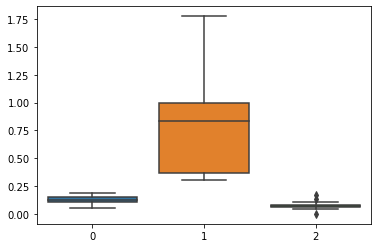

In [83]:
sns.boxplot(y=Ds,x=C)

C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

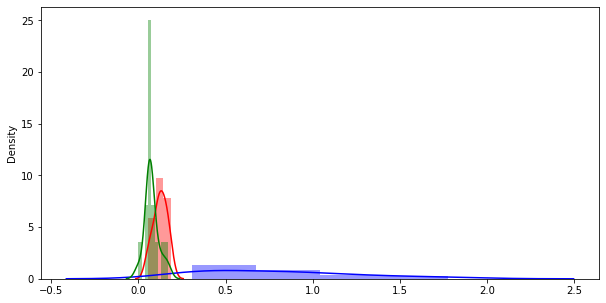

In [84]:
plt.figure(figsize=(10,5))
colors = np.array(['red','blue','green'])
for c in np.unique(C):
    sns.distplot(x=Ds[C==c],color= colors[c])

In [85]:
feature_shaplets,quality_scores = zip(*kShapelets)

In [109]:
dataset = np.zeros((N,k))
for i,feature in enumerate(tqdm(feature_shaplets)):
    l = len(feature)
    Wl = create_Wl(T,l)
    Ds = findDistances(feature,Wl)
    dataset[:,i] = Ds

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.22it/s]


In [110]:
N = 1000
T_test,C_test = generate_dataset(N,20,30)
dataset_test = np.zeros((N,k))
for i,feature in enumerate(tqdm(feature_shaplets)):
    l = len(feature)
    Wl = create_Wl(T_test,l)
    Ds = findDistances(feature,Wl)
    dataset_test[:,i] = Ds

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


In [111]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [112]:
sc = StandardScaler()
model = LogisticRegressionCV().fit(sc.fit_transform(dataset),C)

In [113]:
np.mean(model.predict(sc.transform(dataset)) == C)

1.0

In [114]:
from sklearn.metrics import classification_report

In [115]:
print(classification_report(C_test,model.predict(sc.transform(dataset_test))))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       322
           1       1.00      1.00      1.00       321
           2       0.87      1.00      0.93       357

    accuracy                           0.95      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [116]:
model.predict(sc.transform(dataset_test))

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [117]:
np.mean(model.predict(sc.transform(dataset_test)) == C_test)

0.946